DFM / online-coupled bloom tracer Run
--

This version matches with run_dfm_bloom_tracers_v02 / bloom_tracers_v03.

Copied from plot_dfm_bloom_tracers_v03, this notebook drops the temperature calibration
code, focuses on growth potential.

In [1]:
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")
from stompy import utils, xr_utils, memoize
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
from stompy.plot import plot_utils, plot_wkb
from stompy.grid import unstructured_grid
import stompy.plot.cmap as scmap
from stompy.spatial import proj_utils, field
from stompy.io.local import noaa_coops
from matplotlib import gridspec
import pdb

import os, time
import numpy as np
import xarray as xr
import pandas as pd

from matplotlib import cm

from IPython.display import Video
import time
import six
import datetime

In [3]:
# These online-coupled dfm-dwaq runs.

# Main run
#run_dir="bloom_tracers_v03/run_20220802T1200_20220830T0000_v00"
# Updated forcing for ocean BC, air temp, fix longitude for solar rad.
# run_dir="bloom_tracers_v04/run_20220802T1200_20220830T0000_v02"
# swim_speeds=[10]
# Switch to just 5 m/d, update temperature parameters:
# Use CdWind for Stanton and Dalton numbers
# run_dir="bloom_tracers_v05/run_20220802T1200_20220830T0000_v00"
# swim_speeds=[5]

# Get everything packaged up cleanly on ds/multiugrid
results=[]

In [78]:
if 0:
    run_dir="bloom_tracers_v06/run_20220802T1200_20220830T0000_v00"
    swim_speeds=[5,10]
    model=dfm.DFlowModel.load(run_dir)
    ds=model.map_dataset()
    ds['swim_speed']=('swim_speed',),[5.0,10.0]
    ds['run_dir']=(),run_dir
    ds['label'] = (),"v06 No temperature"
    results.append(ds)

In [79]:
if 0:
    run_dir="bloom_tracers_v07/run_20220802T1200_20220830T0000_v00"
    swim_speeds=[5,10]
    model=dfm.DFlowModel.load(run_dir)
    ds=model.map_dataset()
    ds['swim_speed']=('swim_speed',),[5.0,10.0]
    ds['run_dir']=(),run_dir
    ds['label'] = (),"v07 Temperature"
    results.append(ds)

In [80]:
if 0:
    run_dir="bloom_tracers_v08/run_20220802T1930_20220830T0000_v00"
    swim_speeds=[5,10]
    model=dfm.DFlowModel.load(run_dir)
    ds=model.map_dataset()
    ds['swim_speed']=('swim_speed',),[5.0,10.0]
    ds['run_dir']=(),run_dir
    ds['label'] = (),"v08 Temp, ACSPO IC"
    results.append(ds)

In [4]:
if 1: 
    # with temperature
    # 0-4: lagrangian releases
    # 5-9: uniform releases for growth potential
    #    5: 5 m/d
    #    6: 10 m/d
    #    7: 0 m/d
    #    8: 80 micron/s = 6.912 m/d
    #    9: 80 micron/s diurnal
    run_dir="bloom_tracers_v12/run_20220804T1820_20220830T0000_v00"
    swim_speeds=[5,10,0,6.912, 6.912j, 5, 10,0,6.912, 6.921j] # j implies diurnal
    model=dfm.DFlowModel.load(run_dir)
    ds=model.map_dataset()
    ds['swim_speed']=('tracer',),swim_speeds
    ds['release']=('tracer',),['alameda']*5 + ['uniform']*5
    ds['run_dir']=(),run_dir
    ds['label'] = (),"v12 Temperature"
    results.append(ds)

    # 2025-04-11: While there is a more recent run, v16, with an updated Kd field,
    # it only has lagrangian tracers, not useful for growth potential.

INFO:utils:2/16
INFO:utils:4/16
INFO:utils:6/16
INFO:utils:8/16
INFO:utils:10/16
INFO:utils:12/16
INFO:utils:14/16


In [5]:
def fmt_swim_mpd(s):
    if np.isreal(s):
        return "%.1f m/d"%np.real(s)
    else:
        return "%.1f m/d diurnal"%(np.imag(s))

In [6]:
grid=results[0].grid
grid_poly=grid.boundary_polygon()

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3212664407.249243, 15 potential interiors


In [7]:
# Representative points
# manual picks from plot
l2m=proj_utils.mapper('WGS84','EPSG:26910')
sites=dict( Alcatraz = np.r_[550030,4.18629e6],
            Alameda = np.r_[562410, 4.17998e6],
            SMB = np.r_[566900, 4.16085e6], 
            Pier17 = np.r_[553056, 4184134],
            SHL = l2m( [-122.243,37.63079] ),
            SLM = l2m( [-122.218,37.6742]),
            HAY = l2m( [-122.201,37.61174]))

Plotting All Fields
--

In [85]:
# dropped extract_tracers()

In [8]:
# tide, insolation time series
@memoize.memoize()
def cimis():
    print("Reloading cimis")
    cimis_ds=xr.open_dataset('/richmondvol1/hpcshared/inputs/cimis/union_city-hourly-2022_bloom.nc')
    # Starts as PST, but the model is UTC.
    cimis_ds=cimis_ds.set_coords('time').swap_dims({'Date':'time'})
    cimis_ds['time']=cimis_ds['time']+np.timedelta64(8,'h')
    sol_rad=cimis_ds['HlySolRad'].values
    sol_rad=utils.fill_invalid(sol_rad)
    cimis_ds['sol_rad']=('time',),sol_rad
    sel = utils.select_increasing(cimis_ds.time.values)
    return 1.85*cimis_ds['sol_rad'].isel(time=sel)

c=ds.grid.select_cells_nearest([564400,4161700])
tides_da = ds['s1'].isel(nFlowElem=c)


def tide_panel(ax,t):
    t_off=np.timedelta64(7,'h') # PDT
    da_cimis = cimis()
    ax.fill_between(da_cimis.time-t_off,da_cimis, color='orange', lw=0.8) # fc='#eeee00', ec='#eeee00',lw=0.8) 
    ax_tides=ax.twinx()
    ax_tides.plot(tides_da.time-t_off, tides_da,lw=1.25)
    ax_tides.yaxis.set_visible(0)
    #ax.yaxis.set_visible(0)
    ax_tides.axis('off')
    ax.axis(ymin=0,ymax=2000,xmin=ds.time.values[0]-t_off,xmax=ds.time.values[-1]-t_off)
    ax.axvline(t-t_off,color='k',lw=1.25)
    plt.setp(ax.get_xticklabels(),visible=0)

#fig,ax=plt.subplots(figsize=(8,1.3))
#tide_panel(ax,ds.time.values[385])

Growth Potential
==

In [9]:
# Largely based on the GP code in bloom-timing.ipynb

In [12]:
# hourly output.
# conc0, radc0. For growth potential I just want conc0 and instantaneous rad.
# should include CIMIS solar radiation, time/space variable Kd
# Even though the substance file requests these outputs, they do not exist in the map
# or history output, so reconstruct. 

import common
from common import k_indef

class GrowthPotentialMap:
    map_ds = None
    # This is from some water column code in bloom_timing.ipynb
    Gmax = 1.0
    Isat = 25
    conc_fld='conc0'
    Kd_source = None

    def __init__(self,**kw):
        utils.set_keywords(self,kw)
        self.centers=self.map_ds.grid.cells_centroid()

    @memoize.imemoize()
    def solar_rad_timeseries(self):
        return model.read_tim( os.path.join(model.run_dir,'RadSurf.tim'), columns=['RadSurf'] )
        
    def get_solar_radiation(self, tidx):
        # Could also get solar radiation from original CIMIS data
        sol_rad = self.solar_rad_timeseries()
        t=self.map_ds.time.values[tidx]
        return np.interp( t, sol_rad.time, sol_rad.RadSurf )

    @memoize.imemoize()
    def Kd_spacetime(self):
        Kd_source = self.Kd_source or os.path.join(model.run_dir,'seg-ExtVl.nc')
        return xr.open_dataset(Kd_source)
        
    def get_Kd(self, tidx):
        extvl_ds = self.Kd_spacetime()
        t = self.map_ds.time.values[tidx]
        extvl_fld = field.SimpleGrid.from_curvilinear(extvl_ds.x.values,
                                                      extvl_ds.y.values,
                                                      extvl_ds.ExtVl.sel(time=t,method='nearest').values)
        return extvl_fld(self.centers)

    #@memoize.imemoize(lru=300)
    def growth_potential(self,tidx):
        """
        vertically integrated growth rate, weighted by concentration distribution.
        returns dataframe in order of grid cells
        """
        results = [] 
        snap=self.map_ds.isel(time=tidx)
        
        # grab these for all cells, layers, just this timestep.
        conc = snap[self.conc_fld].values.clip(0.0)
        z_int = xr_utils.decode_sigma(snap, self.map_ds['LayCoord_w']).values

        sol_rad = self.get_solar_radiation(tidx).clip(1e-12,2000)
        Kd = self.get_Kd(tidx)

        # Vectorize over the domain.
        if 1:
            depths=-z_int[:,:] + z_int[:,-1:] # [cell,interface]
            klight_indefs = common.k_indef(depths,Kd[:,None], sol_rad, self.Isat)
            Hs=depths[:,0]
            thresh=1e-10
            conc_avgs = (np.sum(conc[:,:]*np.diff(z_int[:,:],axis=1),axis=1) / Hs).clip(thresh)
            klight_defs = np.diff(-klight_indefs,axis=1)
            growth_ints = self.Gmax*np.sum(conc*klight_defs,axis=1) / conc_avgs
            growth_ints[ conc_avgs<=thresh ] = 0.0
            growth_avgs = growth_ints / Hs
            growth_mixeds = self.Gmax*np.sum(klight_defs,axis=1) / Hs
            growth_mixeds[ conc_avgs<=thresh ] = 0.0

            #if not np.allclose( growth_ints, self.results['growth_int'].values ):
            #    import pdb
            #    pdb.set_trace()
            self.results = pd.DataFrame()
            self.results['cell'] = np.arange(self.map_ds.grid.Ncells())
            self.results['tIdx'] = tidx
            self.results['growth_int'] = growth_ints
            self.results['growth_avg'] = growth_avgs
            self.results['growth_mixed'] = growth_mixeds
            
        self.results.attrs['time'] = self.map_ds.time.values[tidx]

        self.results.attrs['source_dataset']=self.map_ds['label'].item()
        self.results.attrs['conc_field'] = self.conc_fld
        conc_idx = int(self.conc_fld.replace('conc',''))
        self.results.attrs['swim_speed'] = fmt_swim_mpd(self.map_ds['swim_speed'].values[conc_idx])
        self.results.attrs['release'] = self.map_ds['release'].values[conc_idx]
        return self.results
    
    def growth_potential_one(self, conc, sol_rad, Kd, z_int):
        res = {}
            
        # z_int is positive up, and holds negative values, from -H to eta
        # But k_indef is expecting z to be positive down, starting from z=0 at the surface
        # This gets z_int as positive down, z=0 at the surface.
        # Still ordered bed->surface, though.
        depth=-z_int + z_int[-1]
        klight_indef = common.k_indef(depth,Kd,sol_rad,self.Isat)

        # separate effects of tidal mixing, phase of tides w.r.t. daylight
        #kfullsun_indef=k_indef(-self.z_int,self.Kd,1000,self.Isat)
        #sol_rad_ideal = utils.ideal_solar_rad(self.t)
        #kideal_indef  = k_indef(-self.z_int,self.Kd,sol_rad_ideal,self.Isat)
        #sol_rad_diurnal = utils.ideal_solar_rad(self.t, declination=False)
        #kdiurnal_indef  = k_indef(-self.z_int,self.Kd,sol_rad_diurnal,self.Isat)

        # Concentration weighted average
        # negate klight_indef because depth is descending.
        H=z_int[-1] - z_int[0]
        
        # This assumes the layers are evenly spaced.
        #conc_avg=conc.mean()
        # This accounts for stretching
        conc_avg = np.sum(conc*np.diff(z_int)) / H

        if conc_avg > 1e-10:
            klight_def = np.diff(-klight_indef)
            growth_int = res['growth_int'] = self.Gmax*np.sum(conc*klight_def) / conc_avg
            res['growth_avg'] = growth_int / H            
            res['growth_mixed']=self.Gmax*np.sum(klight_def) / H
        else:
            res['growth_avg'] = 0.0
            res['growth_int'] = 0.0
            res['growth_mixed'] = 0.0

        return res

    def transcribe(self):
        """
        Calculate for all time steps, package into netcdf with grid
        """
        
        all_df=[]
        for tidx in utils.progress(range(self.map_ds.dims['time'])):
            df = self.growth_potential(tidx=tidx)
            df['time'] = df.attrs['time']
            all_df.append(df)
            
        # Stuff into netcdf, then come back and tidal average
        df_comb = pd.concat(all_df)
    
        df2=df_comb.set_index(['time','cell'])
        df2.head()
        
        ds_results = xr.Dataset.from_dataframe(df2)
        del ds_results['tIdx']
        self.map_ds.grid.write_xarray(ds_results)
        ds_results['NetNode_z'] = ('node',), self.map_ds.grid.nodes['NetNode_z']        

        # Copy attributes from any of the individual frames
        df=all_df[0]
        for k in df.attrs:
            if k != 'time':
                ds_results.attrs[k] = df.attrs[k]
            
        return ds_results



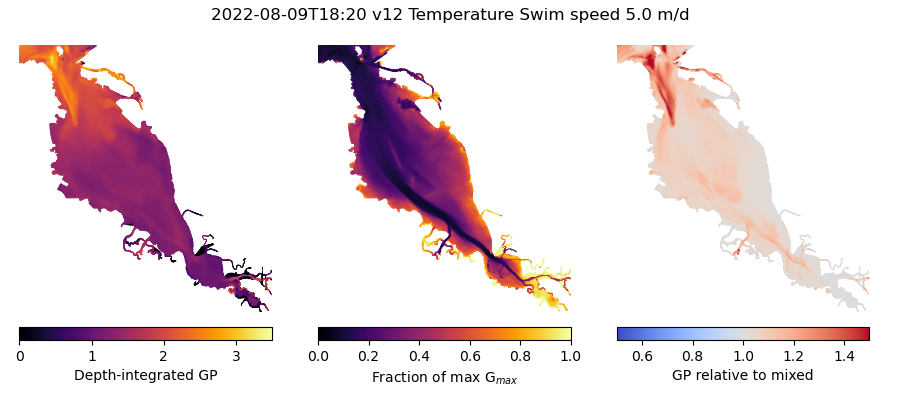

In [17]:
def basic_gp_figure(gs,tidx):
    df = gs.growth_potential(tidx=tidx) 
    fig,axs = plt.subplots(1,3, figsize=(9,4.0))
    for ax in axs:
        ax.axis('off')
        ax.set_adjustable('datalim')
    
    def plot_cells(ax,v,label,**kw):
        coll = gs.map_ds.grid.plot_cells(values=v,ax=ax,**kw)
        coll.set_lw(0.5)
        coll.set_edgecolor('face')
        plt.colorbar(coll, orientation='horizontal',ax=ax, label=label, pad=0.05, fraction=0.1)
        
    # Growth potential
    plot_cells(axs[0],df['growth_int'],'Depth-integrated GP', cmap='inferno', clim=[0,3.5])
    plot_cells(axs[1],df['growth_avg'],'Fraction of max G$_{max}$', cmap='inferno', clim=[0,1])
    
    # Relative to no swimming
    plot_cells(axs[2], df['growth_avg'] / df['growth_mixed'], cmap='coolwarm', clim=[0.5,1.5],
               label='GP relative to mixed')
    
    t_str = str(df.attrs['time'])[:16]
    fig.suptitle(f"{t_str} {df.attrs['source_dataset']} Swim speed {df.attrs['swim_speed']}")
    fig.tight_layout()
    for ax in axs:
        ax.axis((548258., 592431., 4146961., 4181391.))


gs = GrowthPotentialMap(map_ds=results[0],conc_fld='conc5')
basic_gp_figure(gs,tidx=120)

In [ ]:
# Compare same tracer, different KD
gs_Kd = GrowthPotentialMap(map_ds=results[0],conc_fld='conc5',
                           Kd_source='bloom_tracers_v16/run_20220804T1820_20220830T0000_v00/seg-ExtVl.nc')
basic_gp_figure(gs,tidx=120)

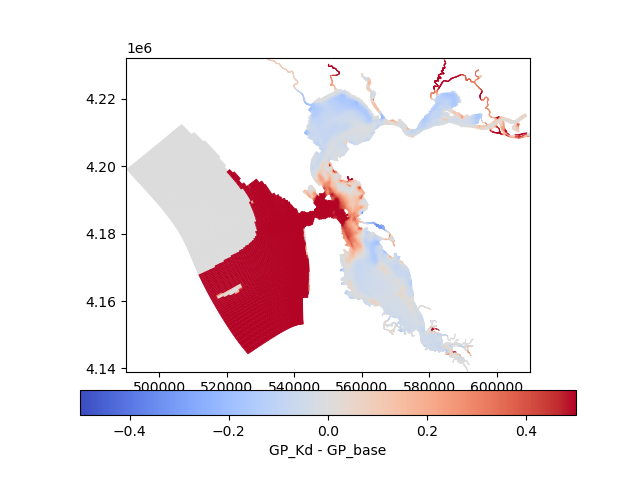

In [29]:
# Looks very similar...
from matplotlib import colors

tidx=120
df_base = gs.growth_potential(tidx=tidx)
df_Kd   = gs_Kd.growth_potential(tidx=tidx)

fig,ax = plt.subplots()
scal = df_Kd['growth_int'] - df_base['growth_int']
coll = gs.map_ds.grid.plot_cells(values=scal,ax=ax,cmap='coolwarm',norm=colors.CenteredNorm(0.0))
coll.set_clim([-0.5,0.5])
coll.set_lw(0.5)
coll.set_edgecolor('face')
plt.colorbar(coll, orientation='horizontal',ax=ax, label="GP_Kd - GP_base", pad=0.05, fraction=0.1)

In [22]:
df_base.head()

,cell,tIdx,growth_int,growth_avg,growth_mixed
0,0,120,0.643527,0.545401,0.529165
1,1,120,0.008996,0.963828,0.963828
2,2,120,0.009012,0.965039,0.965039
3,3,120,0.759342,0.370287,0.338954
4,4,120,0.720084,0.491009,0.469079


In [23]:
df_Kd.head()

,cell,tIdx,growth_int,growth_avg,growth_mixed
0,0,120,0.997676,0.845549,0.839594
1,1,120,0.009015,0.965862,0.965862
2,2,120,0.009019,0.965868,0.965868
3,3,120,1.357566,0.662006,0.634320
4,4,120,1.156115,0.788330,0.777030


In [90]:
# Calculate GP across all runs, tracers
calc_hourly=True
calc_daily =True

def clear_nc(nc_filename):
    # Force xarray to reread later on.
    if os.path.exists(nc_filename): 
        tmp = xr.open_dataset(nc_filename)
        tmp.close()
        del tmp
    while os.path.exists(nc_filename):
        print(f"Removing {nc_filename}")
        os.unlink(nc_filename)
        time.sleep(1.0)
    
for result in results:
    run_dir=result['run_dir'].item()
    print(f"Processing results from {run_dir}")

    for conc_fld_idx in [5,6,7,8,9]: # for v12, these are the growth potential tracers.
        conc_fld = f'conc{conc_fld_idx}'
        hourly_fn=os.path.join(run_dir,f"growth_potential_v00_{conc_fld}.nc")
        daily_fn=os.path.join(run_dir,f"growth_potential_daily_v00_{conc_fld}.nc")

        if calc_hourly: clear_nc(hourly_fn)
        if calc_daily: clear_nc(daily_fn)
            
        if calc_hourly:
            print(f"Processing concentration field {conc_fld}")
            gs = GrowthPotentialMap(map_ds=result,conc_fld=conc_fld)
            ds_results = gs.transcribe()
            if os.path.exists(hourly_fn):
                xr.open_dataset(hourly_fn).close() # maybe helps with NFS overwrite
            ds_results.to_netcdf(hourly_fn)
        else:
            print(f"Reading hourly results from {conc_fld}")
            ds_results = xr.open_dataset(hourly_fn)

        if calc_daily:
            # 24-h average
            # Model time is UTC. I want to groupby 24h, but in PDT (-7). So origin should be np.datetime64("2022-08-01 07:00")
            ds_daily = ds_results.resample({'time':'24H'}, origin=np.datetime64("2022-08-01 07:00")).mean()
            # that adds a time dimensions to grid variables, which now needs to be dropped
            for v in ['mesh','node_x','node_y','face_node','edge_node','NetNode_z']:
                if v in ds_daily and 'time' in ds_daily[v].dims:
                    ds_daily[v] = ds_daily[v].isel(time=0)
            ds_daily.to_netcdf(daily_fn)
        else:
            print(f"Skipping daily ({daily_fn})")

Processing results from bloom_tracers_v12/run_20220804T1820_20220830T0000_v00
Removing bloom_tracers_v12/run_20220804T1820_20220830T0000_v00/growth_potential_v00_conc5.nc
Removing bloom_tracers_v12/run_20220804T1820_20220830T0000_v00/growth_potential_daily_v00_conc5.nc
Processing concentration field conc5


INFO:utils:12/607
INFO:utils:23/607
INFO:utils:34/607
INFO:utils:44/607
INFO:utils:54/607
INFO:utils:63/607
INFO:utils:71/607
INFO:utils:81/607
INFO:utils:90/607
INFO:utils:98/607
INFO:utils:106/607
INFO:utils:115/607
INFO:utils:127/607
INFO:utils:139/607
INFO:utils:151/607
INFO:utils:163/607
INFO:utils:176/607
INFO:utils:188/607
INFO:utils:200/607
INFO:utils:213/607
INFO:utils:223/607
INFO:utils:235/607
INFO:utils:247/607
INFO:utils:259/607
INFO:utils:272/607
INFO:utils:285/607
INFO:utils:297/607
INFO:utils:309/607
INFO:utils:320/607
INFO:utils:332/607
INFO:utils:344/607
INFO:utils:355/607
INFO:utils:366/607
INFO:utils:377/607
INFO:utils:388/607
INFO:utils:399/607
INFO:utils:410/607
INFO:utils:421/607
INFO:utils:431/607
INFO:utils:442/607
INFO:utils:454/607
INFO:utils:464/607
INFO:utils:476/607
INFO:utils:487/607
INFO:utils:499/607
INFO:utils:506/607
INFO:utils:517/607
INFO:utils:529/607
INFO:utils:540/607
INFO:utils:551/607
INFO:utils:561/607
INFO:utils:573/607
INFO:utils:585/607
INF

Removing bloom_tracers_v12/run_20220804T1820_20220830T0000_v00/growth_potential_v00_conc6.nc
Removing bloom_tracers_v12/run_20220804T1820_20220830T0000_v00/growth_potential_daily_v00_conc6.nc
Processing concentration field conc6


INFO:utils:30/607
INFO:utils:58/607
INFO:utils:85/607
INFO:utils:111/607
INFO:utils:127/607
INFO:utils:141/607
INFO:utils:154/607
INFO:utils:167/607
INFO:utils:180/607
INFO:utils:200/607
INFO:utils:233/607
INFO:utils:265/607
INFO:utils:297/607
INFO:utils:327/607
INFO:utils:357/607
INFO:utils:385/607
INFO:utils:413/607
INFO:utils:441/607
INFO:utils:463/607
INFO:utils:490/607
INFO:utils:514/607
INFO:utils:540/607
INFO:utils:572/607
INFO:utils:604/607


Removing bloom_tracers_v12/run_20220804T1820_20220830T0000_v00/growth_potential_v00_conc7.nc
Removing bloom_tracers_v12/run_20220804T1820_20220830T0000_v00/growth_potential_daily_v00_conc7.nc
Processing concentration field conc7


INFO:utils:31/607
INFO:utils:63/607
INFO:utils:94/607
INFO:utils:120/607
INFO:utils:145/607
INFO:utils:166/607
INFO:utils:189/607
INFO:utils:211/607
INFO:utils:241/607
INFO:utils:271/607
INFO:utils:301/607
INFO:utils:330/607
INFO:utils:362/607
INFO:utils:389/607
INFO:utils:415/607
INFO:utils:444/607
INFO:utils:473/607
INFO:utils:503/607
INFO:utils:532/607
INFO:utils:564/607
INFO:utils:598/607


Removing bloom_tracers_v12/run_20220804T1820_20220830T0000_v00/growth_potential_v00_conc8.nc
Removing bloom_tracers_v12/run_20220804T1820_20220830T0000_v00/growth_potential_daily_v00_conc8.nc
Processing concentration field conc8


INFO:utils:27/607
INFO:utils:53/607
INFO:utils:81/607
INFO:utils:109/607
INFO:utils:137/607
INFO:utils:161/607
INFO:utils:183/607
INFO:utils:206/607
INFO:utils:235/607
INFO:utils:264/607
INFO:utils:293/607
INFO:utils:322/607
INFO:utils:346/607
INFO:utils:373/607
INFO:utils:402/607
INFO:utils:430/607
INFO:utils:460/607
INFO:utils:493/607
INFO:utils:523/607
INFO:utils:543/607
INFO:utils:567/607
INFO:utils:593/607


Removing bloom_tracers_v12/run_20220804T1820_20220830T0000_v00/growth_potential_v00_conc9.nc
Removing bloom_tracers_v12/run_20220804T1820_20220830T0000_v00/growth_potential_daily_v00_conc9.nc
Processing concentration field conc9


INFO:utils:31/607
INFO:utils:61/607
INFO:utils:92/607
INFO:utils:120/607
INFO:utils:143/607
INFO:utils:166/607
INFO:utils:192/607
INFO:utils:213/607
INFO:utils:237/607
INFO:utils:261/607
INFO:utils:281/607
INFO:utils:308/607
INFO:utils:338/607
INFO:utils:368/607
INFO:utils:397/607
INFO:utils:424/607
INFO:utils:449/607
INFO:utils:474/607
INFO:utils:499/607
INFO:utils:524/607
INFO:utils:550/607
INFO:utils:573/607
INFO:utils:604/607


In [91]:
from matplotlib import cm
import stompy.plot.cmap as scmap

def skew_divergent(cmap,clim,center=1.0):
    alpha=(1.0-clim[0])/(clim[1]-clim[0])
    beta = np.log(0.5) / np.log(alpha)

    return scmap.cmap_transform(cmap,lambda x: x**beta)

INFO:utils:7/26
INFO:utils:14/26
INFO:utils:21/26
INFO:utils:7/26
INFO:utils:14/26
INFO:utils:21/26
INFO:utils:8/26
INFO:utils:15/26
INFO:utils:22/26
INFO:utils:7/26
INFO:utils:14/26
INFO:utils:21/26
INFO:utils:7/26
INFO:utils:14/26
INFO:utils:21/26


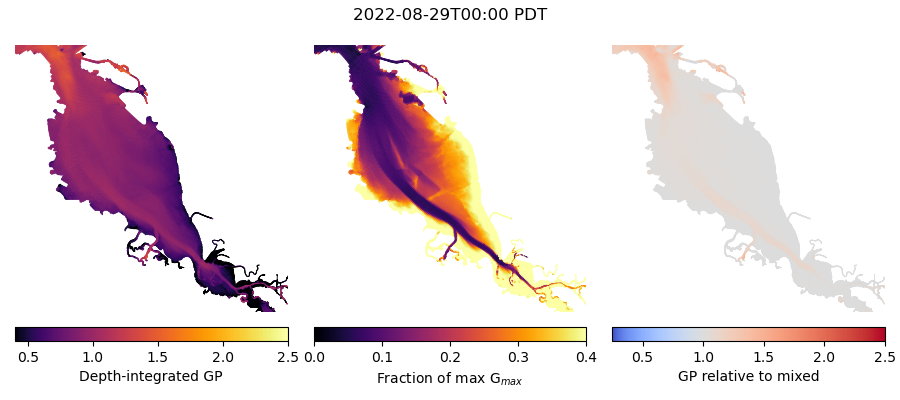

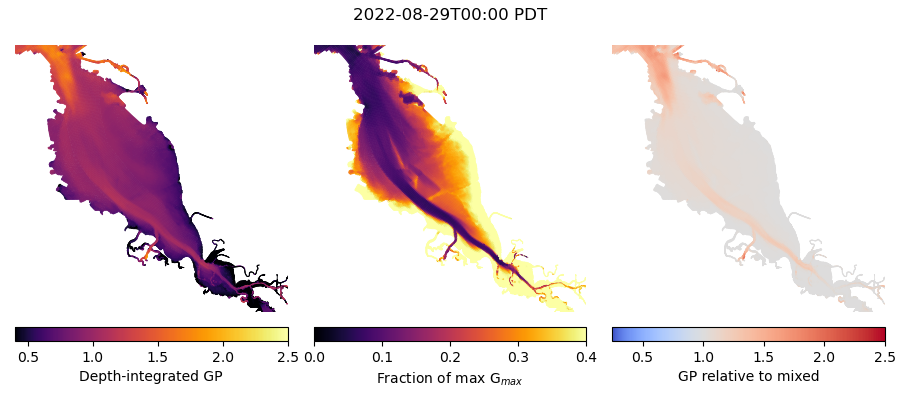

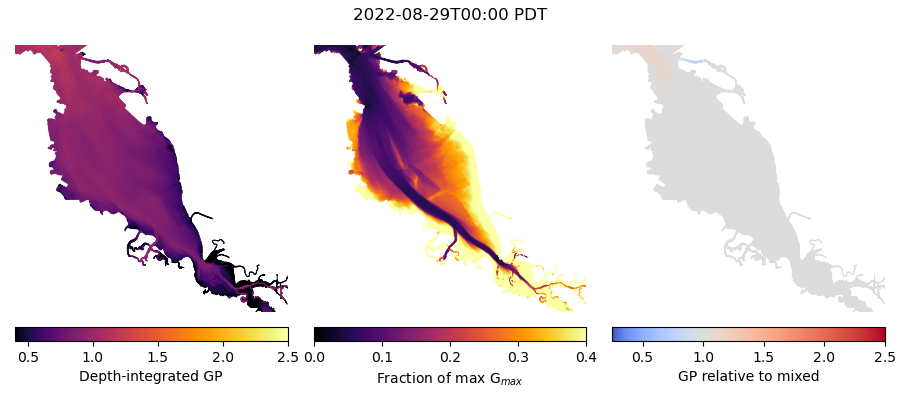

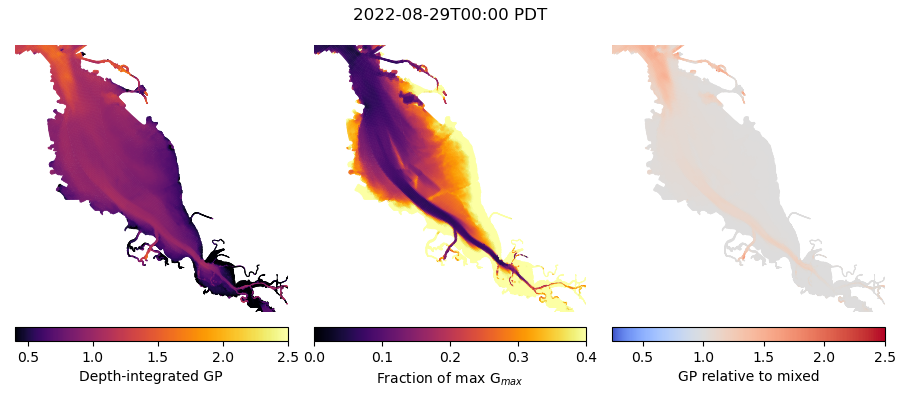

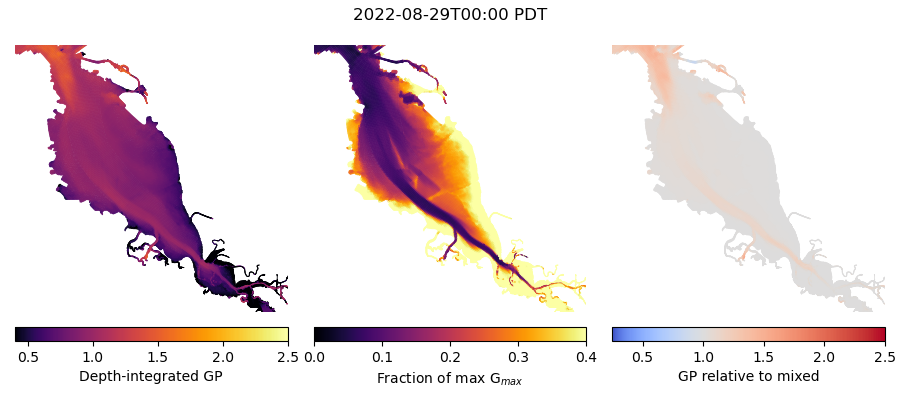

In [92]:
# Render the daily maps
def render_daily_maps(result, conc_fld):
    run_dir = result['run_dir'].item()
    daily_fn = os.path.join(run_dir,f"growth_potential_daily_v00_{conc_fld}.nc")
    ds_daily=xr.open_dataset(daily_fn)

    fig_dir=os.path.join(run_dir,'growth_potential_daily_v00_figs')
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    
    fig,axs = plt.subplots(1,3, figsize=(9,4.0))
    for ax in axs:
        ax.axis('off')
        ax.set_adjustable('datalim')

    def plot_cells(ax,values,label,**kw):
        if callable(values): values=values()
        coll = ds.grid.plot_cells(values=values,ax=ax,**kw)
        coll.set_lw(0.5)
        coll.set_edgecolor('face')
        plt.colorbar(coll, orientation='horizontal',ax=ax, label=label, pad=0.05, fraction=0.1)

    snap=ds_daily.isel(time=0)

    panels=[dict(ax=axs[0], values=lambda: snap['growth_int'], label='Depth-integrated GP', 
                 cmap=scmap.cmap_transform(cm.inferno,lambda x: x**0.7), clim=[0.4,2.5]),
            dict(ax=axs[1],values=lambda: snap['growth_avg'],label='Fraction of max G$_{max}$', cmap='inferno', clim=[0,0.4]),
            dict(ax=axs[2],values=lambda: snap['growth_avg'] / snap['growth_mixed'], 
                 cmap=skew_divergent(cm.coolwarm,[0.25,2.5]), clim=[0.25,2.5],
                 label='GP relative to mixed')
           ]

    for panel in panels:
        plot_cells(**panel)
    
    def time_str(): return str(snap['time'].values - np.timedelta64(7,'h'))[:16] + " PDT"

    fig.suptitle(time_str())
    fig.tight_layout()
    for ax in axs:
        ax.axis((548258., 592431., 4146961., 4181391.))

    for tidx in utils.progress(range(ds_daily.dims['time'])):
        snap=ds_daily.isel(time=tidx)
        for panel in panels:
            values = panel['values']
            if callable(values): values=values()
            panel['ax'].collections[0].set_array(values)
        fig.suptitle(time_str())
        plt.draw()
        fig.savefig(os.path.join(fig_dir,f"growth_potential_{conc_fld}_{tidx:04d}.png"),dpi=200)

#render_daily_maps(results[0],'conc0')
#render_daily_maps(results[0],'conc1')
for conc_idx in [5,6,7,8,9]:
    render_daily_maps(results[0],f'conc{conc_idx}')


In [93]:
# Timeseries at several points
pnts_distributed=[
    (None, [559600,4.1795e6]), # just south of Alameda 
    (None, [556100,4.1820e6]), # epicenter 
    (None, [562200,4.1637e6]), # east of SFO
    (None, [569400,4.1670e6]), # Hayward-ish
]


def ax_grid_bathy(ax,grid):
    ax.set_adjustable('datalim')
    ax.axis('off')
    grid.contourf_node_values(grid.nodes['NetNode_z'],np.linspace(-20,10,64), cmap='terrain',
                              extend='both',ax=ax) 
    ax.axis('equal')
    ax.axis((548258., 592431., 4146961., 4181391.))
    
def fig_gp_timeseries_one(ds):
    gs=gridspec.GridSpec( 3,2, width_ratios=[0.33,0.67])
    
    grid = unstructured_grid.UnstructuredGrid.read_ugrid(ds)
    
    fig=plt.figure(figsize=(9,6))

    ax_grid=fig.add_subplot(gs[:2,0])
    ax_grid_bathy(ax_grid,grid)
    
    markers = [ ax_grid.plot(pnt[0],pnt[1],marker='o',lw=0, mew=1, mec='k') for pnt in pnts]
    colors=[m[0].get_color() for m in markers]
    
    cells=[grid.select_cells_nearest(p) for p in pnts]
    
    ax0=fig.add_subplot(gs[0,1])
    ax1=fig.add_subplot(gs[1,1],sharex=ax0)
    ax2=fig.add_subplot(gs[2,1],sharex=ax0)
    
    for cell,color in zip(cells, colors):
        ax0.plot(ds.time, ds['growth_int'].isel(cell=cell))
        ax1.plot(ds.time, ds['growth_avg'].isel(cell=cell))
        ax2.plot(ds.time, ds['growth_avg'].isel(cell=cell) / ds['growth_mixed'].isel(cell=cell))
    ax0.set_ylabel('Depth-integrated')
    ax1.set_ylabel('Depth-averaged')
    ax2.set_ylabel('Relative to mixed')
    for ax in [ax0,ax1]:
        plt.setp(ax.get_xticklabels(),visible=0)
    fig.autofmt_xdate()
    fig.subplots_adjust(right=0.98, top=0.93,bottom=0.12)
    title = f"{ds.attrs['source_dataset']}  Swimming {ds.attrs['swim_speed']}"
    fig.suptitle(title)
    return fig


def fig_gp_timeseries_multi(dss,lss=['-','--',':','dashdot'],pnts = pnts_distributed):
    gs=gridspec.GridSpec( 3,2, width_ratios=[0.33,0.67])
    
    grid = unstructured_grid.UnstructuredGrid.read_ugrid(dss[0])
    
    fig=plt.figure(figsize=(9,6))

    ax_grid=fig.add_subplot(gs[:2,0])
    ax_grid_bathy(ax_grid,grid)
    
    markers = [ ax_grid.plot(pnt[0],pnt[1],color=col,marker='o',lw=0, mew=1, mec='k') for col,pnt in pnts]
    colors=[m[0].get_color() for m in markers]
    ax0=fig.add_subplot(gs[0,1])
    ax1=fig.add_subplot(gs[1,1],sharex=ax0)
    ax2=fig.add_subplot(gs[2,1],sharex=ax0)
    
    cells=[grid.select_cells_nearest(p) for col,p in pnts]

    for ds,ls in zip(dss,lss):
        ds_label = f"{ds.attrs['source_dataset']}, {ds.attrs['swim_speed']}"
        for cell,color in zip(cells, colors):
            style=dict(color=color,ls=ls)
            if cell==cells[0]:
                style['label']=ds_label
            else:
                style['label']=None
            ax0.plot(ds.time, ds['growth_int'].isel(cell=cell),**style)
            ax1.plot(ds.time, ds['growth_avg'].isel(cell=cell),**style)
            ax2.plot(ds.time, ds['growth_avg'].isel(cell=cell) / ds['growth_mixed'].isel(cell=cell),**style)
    ax0.set_ylabel('Depth-integrated')
    ax1.set_ylabel('Depth-averaged')
    ax2.set_ylabel('Relative to mixed')
    for ax in [ax0,ax1]:
        plt.setp(ax.get_xticklabels(),visible=0)
    fig.autofmt_xdate()
    fig.subplots_adjust(right=0.98, top=0.93,bottom=0.12)
    ax2.legend(loc='upper right',bbox_to_anchor=(-0.1,1.0),frameon=False)
    return fig


cmap=cm.turbo
pnts_thalweg=[
    (cmap(0.1), [556100,4.1820e6]), # epicenter 
    (cmap(0.25), [557500,4.1761e6]), # Hunters Point
    (cmap(0.4), [559000,4.1690e6]), # San Bruno Shoal
    (cmap(0.55), [562200,4.1637e6]), # east of SFO
    (cmap(0.7), [571000,4.15700e6]), # Redwood Ck
    (cmap(0.9), [578290,4.15072e6]), # Dumbarton
]


In [94]:
if 0: # Temp vs no-temp, swim=10 m/d
    dss=[]
    for result in results:
        run_dir = result['run_dir'].item()
        conc_fld = 'conc1'
        daily_fn = os.path.join(run_dir,f"growth_potential_daily_v00_{conc_fld}.nc")
        dss.append(xr.open_dataset(daily_fn))
    
    fig_gp_timeseries_multi(dss, pnts=pnts_distributed) ;
    
    fig_gp_timeseries_multi(dss, pnts=pnts_thalweg) ;

In [95]:
if 0: # Temp vs no-temp, swim=5 m/d
    dss=[]
    for result in results:
        run_dir = result['run_dir'].item()
        conc_fld = 'conc0'
        daily_fn = os.path.join(run_dir,f"growth_potential_daily_v00_{conc_fld}.nc")
        dss.append(xr.open_dataset(daily_fn))
    
    fig_gp_timeseries_multi(dss) ;

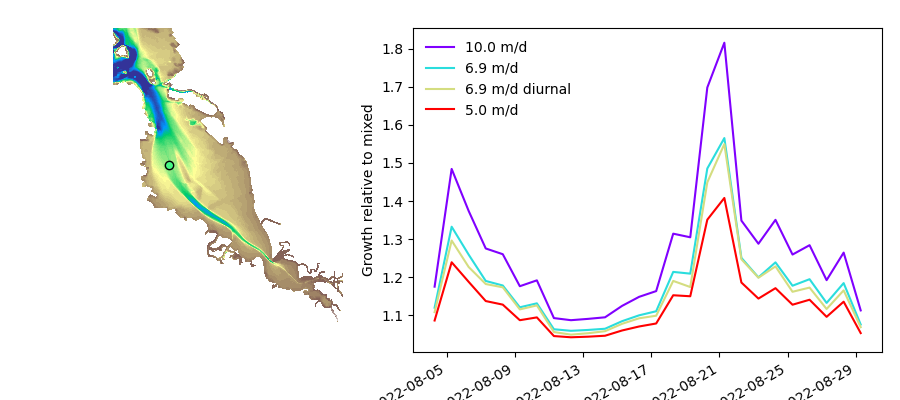

In [96]:
# Swim speeds at one point.
def fig_gp_timeseries_rel_panel(dss,pnts = pnts_distributed, quant='growth_rel'):
    # Just one panel
    gs=gridspec.GridSpec( 1,2, width_ratios=[0.33,0.67])    
    grid = unstructured_grid.UnstructuredGrid.read_ugrid(dss[0])
    
    fig=plt.figure(figsize=(9,4))

    ax_grid=fig.add_subplot(gs[:,0])
    ax_grid_bathy(ax_grid,grid)
    
    markers = [ ax_grid.plot(pnt[0],pnt[1],color=col,marker='o',lw=0, mew=1, mec='k') for col,pnt in pnts]
    # colors=[m[0].get_color() for m in markers]
    ax0=fig.add_subplot(gs[0,1])
    
    cells=[grid.select_cells_nearest(p) for col,p in pnts]

    color=None
    cmap=cm.rainbow
    ls='-'
    for ds_idx,ds in enumerate(dss):
        color = cmap( ds_idx/(len(dss)-1.0))
        ds_label = ds.attrs['swim_speed']
        for cell_idx,cell in enumerate(cells):
            style=dict(color=color)
            if cell_idx==0:
                style['label']=ds_label
            else:
                style['label']=None
            if quant=='growth_int':
                scal = ds['growth_int'].isel(cell=cell)
                ax0.set_ylabel('Depth-integrated')
            elif quant=='growth_avg':
                scal = ds['growth_avg'].isel(cell=cell)
                ax0.set_ylabel('Depth-averaged')
            elif quant=='growth_rel':
                scal = ds['growth_avg'].isel(cell=cell) / ds['growth_mixed'].isel(cell=cell)
                ax0.set_ylabel('Growth relative to mixed')
            else:
                raise Exception(f"Bad quant {quant}")
            ax0.plot(ds.time, scal, **style)
    fig.autofmt_xdate()
    fig.subplots_adjust(right=0.98, top=0.93,bottom=0.12)
    ax0.legend(loc='upper left',
               #bbox_to_anchor=(1,1),
               frameon=False)
    return fig

if 1:
    dss=[]
    result = results[0]
    run_dir = result['run_dir'].item()
    for conc_fld in ['conc6','conc8','conc9','conc5']:# 'conc7' is 0.
        daily_fn = os.path.join(run_dir,f"growth_potential_daily_v00_{conc_fld}.nc")
        dss.append(xr.open_dataset(daily_fn))
    
    # fig_gp_timeseries_multi(dss, pnts=pnts_thalweg[2:3]) ;
    for pnt in pnts_thalweg[2:3]:
        fig = fig_gp_timeseries_rel_panel(dss,pnts=[pnt]) # pnts_thalweg[2:3]); 
None

In [97]:
fig.subplots_adjust(bottom=0.15,left=0.02,top=0.98)

In [98]:
# 5 m/d, 6.9, 6.9 diurnal, 10 m/d
if 0:
    dss=[]
    result = results[0]
    run_dir = result['run_dir'].item()
    for conc_fld in ['conc5','conc8','conc9','conc6']:
        daily_fn = os.path.join(run_dir,f"growth_potential_daily_v00_{conc_fld}.nc")
        dss.append(xr.open_dataset(daily_fn))
    
    fig_gp_timeseries_multi(dss) ;
    fig_gp_timeseries_multi(dss, pnts=pnts_thalweg) ;

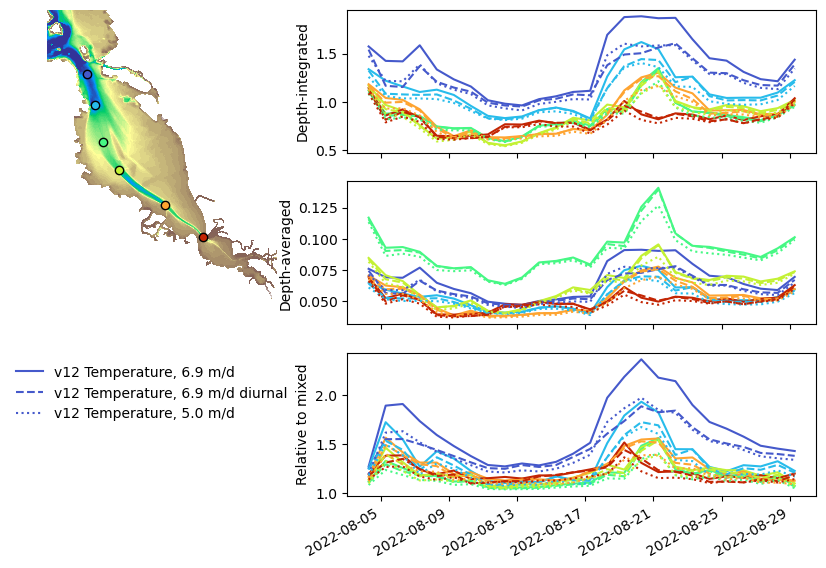

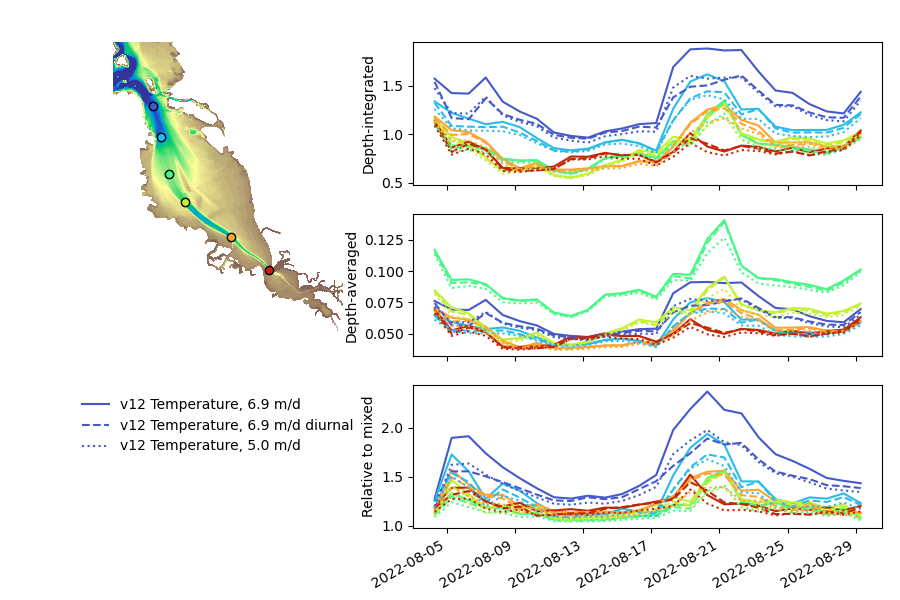

In [99]:
fig_gp_timeseries_multi(dss[1:], pnts=pnts_thalweg)

In [100]:
for result in results:
    run_dir = result['run_dir'].item()
    for conc_fld in ['conc0','conc1']:
        daily_fn = os.path.join(run_dir,f"growth_potential_daily_v00_{conc_fld}.nc")
        ds_daily = xr.open_dataset(daily_fn)
        fig = fig_gp_timeseries_one(ds_daily)


FileNotFoundError: [Errno 2] No such file or directory: b'/richmondvol1/rusty/wy2022_bloom/bloom_tracers_v12/run_20220804T1820_20220830T0000_v00/growth_potential_daily_v00_conc0.nc'